In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn import manifold

import re

In [2]:
cd ..

/Users/gallaghe/Code/nutrition-labels


In [3]:
from nutrition_labels.useful_functions import remove_useless_string


Grants flagged as relevant in EPMC publications not found in grants data: 
{'088600', '091500', '098051', '090500', '088800', '000938', '077008'}
PMIDs flagged as relevant in Wellcome EPMC publications but not found to link to any grants in the grants data: 
{'26220709'}
Grants flagged as relevant in RF data not found in grants data: 
{'10124', '103975/A/14/Z', '100309/A/12/Z', '208519/Z/17/Z', '104128/A/14/Z'}


/Users/gallaghe/Code/nutrition-labels/nutrition_labels/grant_data_processing.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grant_ref['grant_number'] = grant_data['Internal ID'].apply(lambda x: re.sub('/.*','',x))
/Users/gallaghe/Code/nutrition-labels/nutrition_labels/grant_data_processing.py:56: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 56 of the file /Users/gallaghe/Code/nutrition-labels/nutrition_labels/grant_data_processing.py. To get rid of

In [4]:
all_grant_data = pd.read_csv('data/raw/wellcome-grants-awarded-2005-2019.csv')
tagged_data = pd.read_csv('data/processed/training_data.csv')

## Helpful Functions

In [5]:
def vectorise_data(data, vectorizer_type='count', max_features=1000):
    if vectorizer_type == 'count':
        vectorizer = CountVectorizer(analyzer='word',
                                     token_pattern=r'(?u)\b\w+\b',
                                     stop_words='english',
                                     lowercase= True,
                                     max_features = max_features,
                                     ngram_range=(1,2))
    elif vectorizer_type == 'tfidf':
        vectorizer = TfidfVectorizer(analyzer='word',
                                     token_pattern=r'(?u)\b\w+\b',
                                     stop_words='english',
                                     lowercase= True,
                                     max_features = max_features,
                                     ngram_range=(1,2))
    data_vectorized = vectorizer.fit_transform(data)
    
    # vectorizer.get_feature_names()[1:5]
    return vectorizer, data_vectorized

In [6]:
def reduce_data(data_vectorized, type_reduction='TSNE'):
    
    if (type_reduction == 'TruncatedSVD'):
        # PCA does not work on such a sparse matrix, so used TruncatedSVD
        clf = TruncatedSVD(2)
        reduced_data = clf.fit_transform(data_vectorized)
    elif (type_reduction == 'TSNE'):
        tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
        reduced_data = tsne.fit_transform(data_vectorized.toarray())
        
    return reduced_data

In [7]:
def merge_clean_grant_data(all_grant_data, tagged_data):
    print(len(all_grant_data))
    all_grant_data_merged = pd.merge(
        all_grant_data[['Internal ID', 'Description', 'Award Date']],
        tagged_data[['Internal ID', 'relevant']],
        how = 'left', on = 'Internal ID')
    
    all_grant_data_merged['grant_number'] = all_grant_data_merged['Internal ID'].apply(lambda x: re.sub('/.*','',x))
    all_grant_data_merged['Description'] = all_grant_data_merged['Description'].apply(remove_useless_string)
    all_grant_data_merged  = all_grant_data_merged.sort_values(['relevant', 'Award Date'], ascending=False).drop_duplicates(subset = ['grant_number'])
    
    all_grant_data_merged['relevant'] = [int(r) if str(r)!='nan' else 2 for r in all_grant_data_merged['relevant']]
    print(len(all_grant_data_merged))
    return all_grant_data_merged

In [8]:
def stratified_sample(data, sample_size):
    num_relevant = len(data[data['relevant']==1.0])
    sample_size = num_relevant + sample_size # so you get at least all the relevant ones
    data = data.groupby('relevant', group_keys=False).apply(lambda x: x.sample(min(len(x), sample_size)))
    return data

## Merge tag codes with all grant data, and clean grant descriptions

In [9]:
tagged_data['relevant'] = [int(i) for i in (tagged_data['code'] != 5.0).tolist()]
all_grant_data_merged = merge_clean_grant_data(all_grant_data, tagged_data)

16914
14264


In [10]:
all_grant_data_merged.groupby('relevant').count()

,Internal ID,Description,Award Date,grant_number
relevant,,,,
0,696,696,696,696
1,62,62,62,62
2,13506,13506,13506,13506


In [11]:
sample_size=5000
grant_data_sample = stratified_sample(all_grant_data_merged, sample_size)
print(len(grant_data_sample))
grant_data_sample.groupby('relevant').count()

5820


,Internal ID,Description,Award Date,grant_number
relevant,,,,
0,696,696,696,696
1,62,62,62,62
2,5062,5062,5062,5062


## Plot reductions

In [23]:
def plot_reduce(reduced_data, relevant_grant, type_reduction):
    
    not_relevant_i = [i for i,r in enumerate(relevant_grant) if r==0]
    relevant_i = [i for i,r in enumerate(relevant_grant) if r==1]
    unknown_i = [i for i,r in enumerate(relevant_grant) if r==2]
    
    plt.figure(figsize=(10, 10))
    plt.scatter(reduced_data[unknown_i, 0], reduced_data[unknown_i, 1], s=30, alpha = 0.5, c='grey', label='Unknown')
    plt.scatter(reduced_data[not_relevant_i, 0], reduced_data[not_relevant_i, 1], s=30, alpha = 0.6, c='red', label='Not relevant')
    plt.scatter(reduced_data[relevant_i, 0], reduced_data[relevant_i, 1], s=30, alpha = 0.6, c='blue', label='Relevant')
    plt.legend()
    plt.title(f'{type_reduction} reduced data')
    plt.xticks(())
    plt.yticks(())
    plt.show()

## Using sample of the data and max_features = 1000

In [27]:
data = grant_data_sample['Description'].tolist()
print(f'Number of data points: {len(data)}')
relevant_grant = [i for i in grant_data_sample['relevant'].tolist()]

Number of data points: 5820


In [28]:
max_features = 1000

vectorizer_type = 'count'
_, data_vectorized_count = vectorise_data(data, vectorizer_type=vectorizer_type, max_features=max_features)

vectorizer_type = 'tfidf'
_, data_vectorized_tfidf = vectorise_data(data, vectorizer_type=vectorizer_type, max_features=max_features)

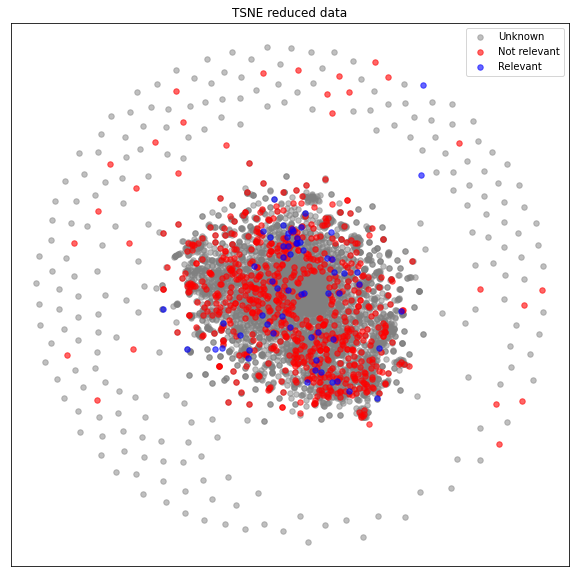

In [30]:
type_reduction = 'TSNE'
reduced_data_count_tsne = reduce_data(data_vectorized_count, type_reduction=type_reduction)
plot_reduce(reduced_data_count_tsne, relevant_grant, type_reduction)

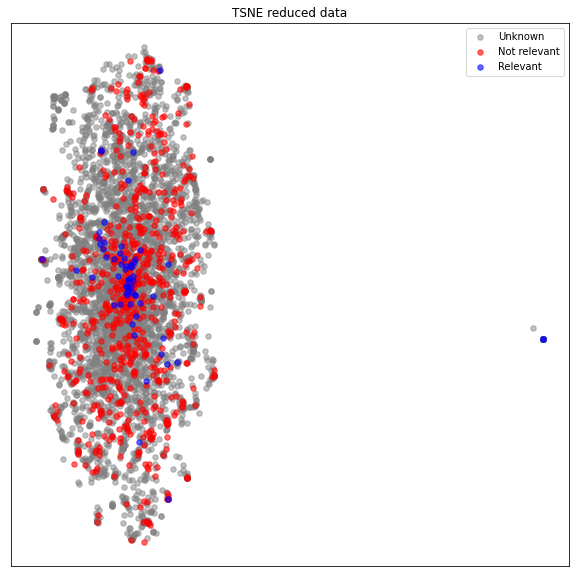

In [31]:
type_reduction = 'TSNE'
reduced_data_tfidf_tsne = reduce_data(data_vectorized_tfidf, type_reduction=type_reduction)
plot_reduce(reduced_data_tfidf_tsne, relevant_grant, type_reduction)

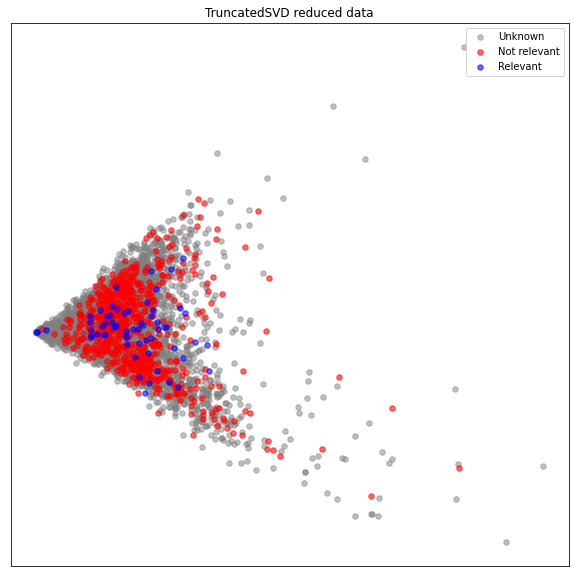

In [32]:
type_reduction = 'TruncatedSVD'
reduced_data_count_svd = reduce_data(data_vectorized_count, type_reduction=type_reduction)
plot_reduce(reduced_data_count_svd, relevant_grant, type_reduction)

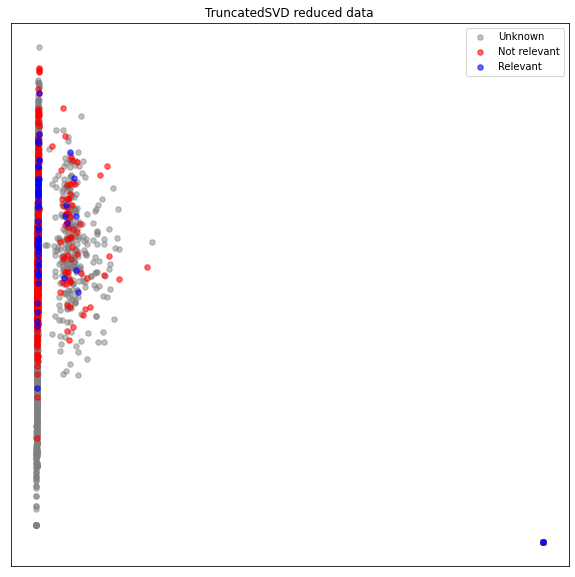

In [33]:
type_reduction = 'TruncatedSVD'
reduced_data_tfidf_svd = reduce_data(data_vectorized_tfidf, type_reduction=type_reduction)
plot_reduce(reduced_data_tfidf_svd, relevant_grant, type_reduction)

## Using all the data and max_features = 1000

In [34]:
data = all_grant_data_merged['Description'].tolist()
print(f'Number of data points: {len(data)}')
relevant_grant = [i for i in all_grant_data_merged['relevant'].tolist()]

Number of data points: 14264


In [35]:
max_features = 1000

vectorizer_type = 'count'
_, data_vectorized_count = vectorise_data(data, vectorizer_type=vectorizer_type, max_features=max_features)

vectorizer_type = 'tfidf'
_, data_vectorized_tfidf = vectorise_data(data, vectorizer_type=vectorizer_type, max_features=max_features)

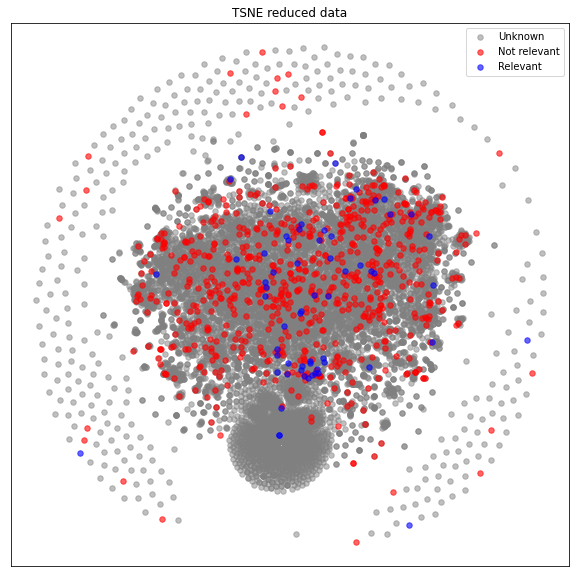

In [36]:
type_reduction = 'TSNE'
all_reduced_data_count_tsne = reduce_data(data_vectorized_count, type_reduction=type_reduction)
plot_reduce(all_reduced_data_count_tsne, relevant_grant, type_reduction)

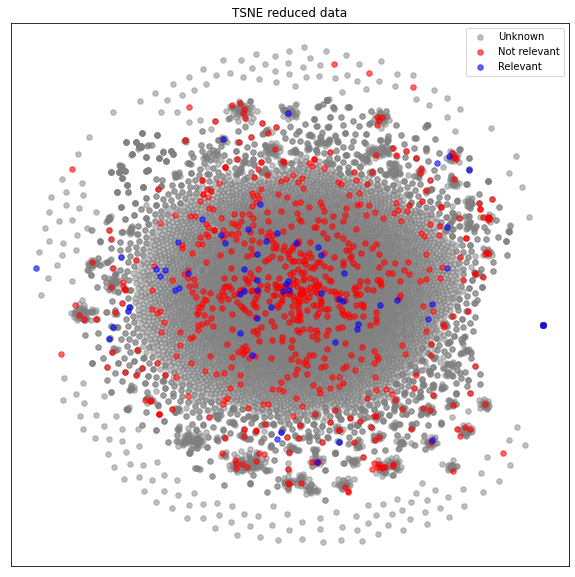

In [37]:
type_reduction = 'TSNE'
all_reduced_data_tfidf_tsne = reduce_data(data_vectorized_tfidf, type_reduction=type_reduction)
plot_reduce(all_reduced_data_tfidf_tsne, relevant_grant, type_reduction)